# Практическое задание
## Урок 6. Градиентный бустинг

### 1. К алгоритму kNN, реализованному на уроке, реализовать добавление весов для соседей по любому из показанных на уроке принципов.

In [1]:
import numpy as np
from sklearn import model_selection
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [2]:
X, y = load_iris(return_X_y=True)

# Для наглядности возьмем только первые два признака (всего в датасете их 4)
X = X[:, :2]

In [3]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=1)

In [4]:
def e_metrics(x1, x2):
    
    distance = 0
    for i in range(len(x1)):
        distance += np.square(x1[i] - x2[i])
    
    return np.sqrt(distance)

#### Будем считать веса по формуле: $$w(d) = \dfrac{1}{(d+a)^b}$$

$d$ - расстояние, $a$ - малая положительная величина, $b$ - настраиваемый параметр.

Для выбранных $k$ соседей будем нормализовать веса.

In [5]:
def knn_weighted(x_train, y_train, x_test, k, b=1):
    
    answers = []
    for x in x_test:
        test_distances = []
            
        for i in range(len(x_train)):
            
            # расчет расстояния от классифицируемого объекта до
            # объекта обучающей выборки
            distance = e_metrics(x, x_train[i])
            
            # Записываем в список значение расстояния и ответа на объекте обучающей выборки
            test_distances.append((distance, y_train[i]))
        
        # создаем словарь со всеми возможными классами
        classes = {class_item: 0 for class_item in set(y_train)}
        
        # Малая величина в формуле весов
        a = 1e-8
        # отсортированный список весов k ближайших соседей (kNN)
        sorted_knn_distances = np.array(sorted(test_distances)[0:k])
        
        # Веса по формуле 1/(d + a)
        knn_weights = 1 / ((sorted_knn_distances[:, 0] + a) ** b)
        # Нормализуем веса
        knn_weights = knn_weights / sum(knn_weights)
        
        # Считаем частоту появления разных классов
        for i, d in enumerate(sorted_knn_distances):
            classes[d[1]] += knn_weights[i]
            
        # Записываем в список ответов класс с наибольшей суммой весов
        answers.append(sorted(classes, key=classes.get)[-1])
    return answers

#### Проверка

In [6]:
def accuracy(pred, y):
    return (sum(pred == y) / len(y))

In [7]:
def get_graph(X_train, y_train, k, b=1):
    cmap = ListedColormap(['red', 'green', 'blue'])
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])

    h = .02

    # Расчет пределов графика
    x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
    y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Получим предсказания для всех точек
    Z = knn_weighted(X_train, y_train, np.c_[xx.ravel(), yy.ravel()], k, b)

    # Построим график
    Z = np.array(Z).reshape(xx.shape)
    plt.figure(figsize=(7,7))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Добавим на график обучающую выборку
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(f"k = {k}, w = 1 / (d + a)^b")
    plt.show()

1) $w(d) = \dfrac{1}{d+a}$

Точность алгоритма при k = 3, b = 1: 0.733


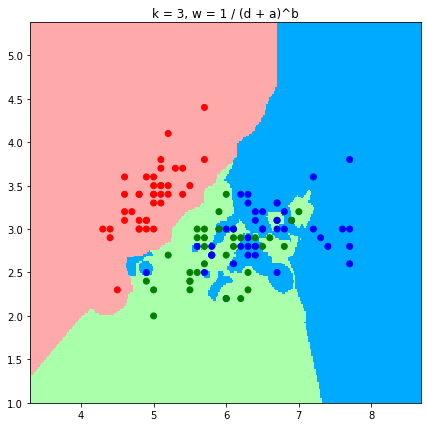

In [8]:
k = 3
b = 1
y_pred = knn_weighted(X_train, y_train, X_test, k, b)
print(f'Точность алгоритма при k = {k}, b = {b}: {accuracy(y_pred, y_test):.3f}')
get_graph(X_train, y_train, k, b)

2) $w(d) = \dfrac{1}{(d+a)^2}$

Точность алгоритма при k = 3, b = 2: 0.733


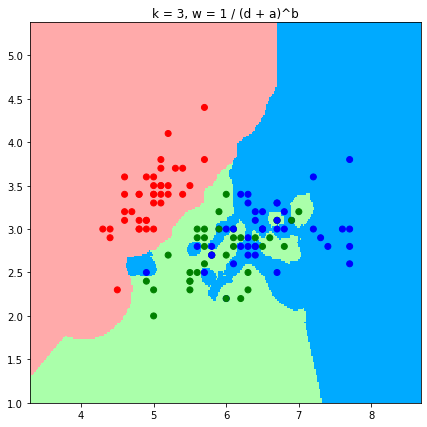

In [9]:
k = 3
b = 2
y_pred = knn_weighted(X_train, y_train, X_test, k, b)
print(f'Точность алгоритма при k = {k}, b = {b}: {accuracy(y_pred, y_test):.3f}')
get_graph(X_train, y_train, k, b)

### 2.* Написать функцию подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние и построить график ее зависимости от количества кластеров k (взять от 1 до 10) для выборки данных из данного урока (создать датасет, как в методичке).

In [10]:
from sklearn.datasets import make_blobs
import random

X, y = make_blobs(n_samples=100, random_state=1)

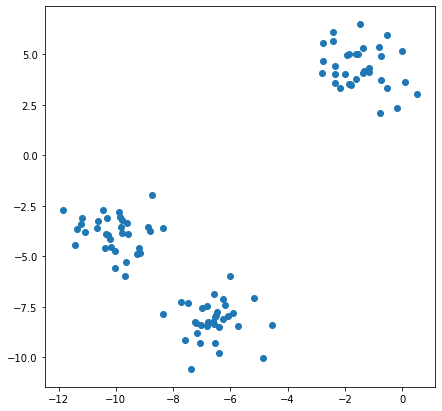

In [11]:
plt.figure(figsize=(7,7))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

In [12]:
def kmeans(data, k, max_iterations, min_distance):
    # Создадим словарь для классификации
    classes = {i: [] for i in range(k)}
    
    # инициализируем центроиды как первые k элементов датасета
    centroids = [data[i] for i in range(k)]
    
    for _ in range(max_iterations):
        # классифицируем объекты по центроидам
        for x in data:
            # определим расстояния от объекта до каждого центроида
            distances = [e_metrics(x, centroid) for centroid in centroids]
            # отнесем объект к кластеру, до центроида которого наименьшее расстояние
            classification = distances.index(min(distances))
            classes[classification].append(x)
        
        # сохраним предыдущие центроиды в отдельный список для последующего сравнения сновыми
        old_centroids = centroids.copy()
        
        # пересчитаем центроиды как среднее по кластерам
        for classification in classes:
            centroids[classification] = np.average(classes[classification], axis=0)
            
        # сравним величину смещения центроидов с минимальной
        optimal = True
        for centroid in range(len(centroids)):
            if np.sum(abs((centroids[centroid] - old_centroids[centroid]) / old_centroids * 100)) > min_distance:
                optimal = False
                
        # если все смещения меньше минимального, останавливаем алгоритм  
        if optimal:
            break
    
    return old_centroids, classes

#### Функция подсчета метрики качества кластеризации как среднее квадратичное внутриклассовое расстояние
$$\sum_{k=1}^{K}\frac{1}{|k|}\sum_{i=1}^{l}[a(x_{i})=k]\rho^{2}(x_{i}, c_{k}),$$

In [13]:
def mean_square_intracluster_dist(centroids, classes):
    metric = 0
    for i, centroid in enumerate(centroids):
        k = len(classes[i])
        metric += sum([np.square(e_metrics(x, centroid)) for x in classes[i]]) / k
    return metric

#### Получаем список значений метрик для k от 1 от 10

In [14]:
max_iterations = 10
min_distance = 1e-4

k_list = list(range(1, 11))
metrics = []

for k in k_list:
    centroids, clusters = kmeans(X, k, max_iterations, min_distance)
    metrics.append(mean_square_intracluster_dist(centroids, clusters))

#### Строим график

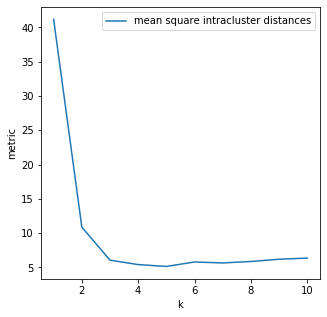

In [15]:
plt.figure(figsize=(5,5))
plt.plot(k_list, metrics, label='mean square intracluster distances')

plt.xlabel('k')
plt.ylabel('metric')

plt.legend(loc='upper right')

plt.show()

#### Вывод

При k = 3 график выходит на плато, значит 3 - оптимальное число кластеров